In [1]:
# Imports
from sklearn.svm import OneClassSVM
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor
from nltk.corpus import reuters
import numpy as np
import tensorflow as tf
import tensorflow_hub as hub
import matplotlib.pyplot as plt
import pandas as pd
import nltk
import time
import sys
import torch
from sklearn.metrics import f1_score
from nltk import word_tokenize
from nltk.corpus import stopwords
import string, re
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score, balanced_accuracy_score 
from sklearn.preprocessing import StandardScaler
import seaborn as sns
from sklearn.metrics import (confusion_matrix, precision_recall_curve, auc,roc_curve)
from keras.models import Model, load_model
from keras.layers import Input, Dense
from keras.callbacks import ModelCheckpoint, TensorBoard
from keras import regularizers
from flair.embeddings import FlairEmbeddings,ELMoEmbeddings, WordEmbeddings
from flair.embeddings import DocumentPoolEmbeddings, FastTextEmbeddings ,Sentence, XLNetEmbeddings
from sentence_transformers import SentenceTransformer
from sklearn.neural_network import MLPClassifier

/opt/conda/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/opt/conda/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/opt/conda/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/opt/conda/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:529: FutureWarning: Passing (type, 1) or 

In [2]:
def clean_text(text: str, rm_numbers=True, rm_punct=True, rm_stop_words=True, rm_short_words=True):
    """ Function to perform common NLP pre-processing tasks. """

    # make lowercase
    text = text.lower()
    # remove punctuation
    if rm_punct:
        text = text.translate(str.maketrans(string.punctuation, ' ' * len(string.punctuation)))
    # remove numbers
    if rm_numbers:
        text = re.sub(r'\d+', '', text)
    # remove whitespaces
    text = text.strip()
    # remove stopwords
    if rm_stop_words:
        stop_words = set(stopwords.words('english'))
        word_tokens = word_tokenize(text)
        text_list = [w for w in word_tokens if not w in stop_words]
        text = ' '.join(text_list)
    # remove short words
    if rm_short_words:
        text_list = [w for w in text.split() if len(w) >= 3]
        text = ' '.join(text_list)
    return text

# Train data  
def reuters_train_dataset(train=True, test=False, clean_txt=True):
    doc_ids = reuters.fileids()
    splits = [split_set for (requested, split_set) in [(train, 'train'), (test, 'test')] if requested]
    print('Loading Train data ... ')
    for split_set in splits:
        split_set_doc_ids = list(filter(lambda doc: doc.startswith(split_set), doc_ids))
        train_data = []
        for id in split_set_doc_ids:
            if clean_txt:
                text = clean_text(reuters.raw(id))
            else:
                text = ' '.join(word_tokenize(reuters.raw(id)))
            labels = reuters.categories(id)
            train_data.append({
              'text': text,
              'label': labels[0],
          })
    return train_data
# Test data          
def reuters_test_dataset(train=False, test=True, clean_txt=True):
    doc_ids = reuters.fileids()
    splits = [split_set for (requested, split_set) in [(train, 'train'), (test, 'test')] if requested]
    print('Loading Test data ... ')
    for split_set in splits:
        split_set_doc_ids = list(filter(lambda doc: doc.startswith(split_set), doc_ids))
        test_data = []
        for id in split_set_doc_ids:
            if clean_txt:
                text = clean_text(reuters.raw(id))
            else:
                text = ' '.join(word_tokenize(reuters.raw(id)))
            labels = reuters.categories(id)
          
            test_data.append({
              'text': text,
              'label': labels[0],
          })
    return test_data


# Various Embeddings - Bert, Universal Sentence Encoder, Infersent, GloVe, Fasttext, Ensemble Embeddings(Flair + GloVe)

# Embedding using Universal Sentence Encoder
def embed_module(module):
    with tf.Graph().as_default():
        sentences = tf.placeholder(tf.string)
        embed = hub.Module(module)
        embeddings = embed(sentences)
        session = tf.train.MonitoredSession()
    return lambda x: session.run(embeddings, {sentences: x})

def use_embeddings():
    train_data_list = []
    test_data_list = []
    module_url = "/opt/notebooks/embedding_model/"
    # Import the Universal Sentence Encoder's TF Hub module
    embed = embed_module(module_url)
    train_data_list = embed(final_train['text'].tolist())
    test_data_list = embed(final_test['text'].tolist())
    val_data_list = embed(final_val['text'].tolist())
    return train_data_list, test_data_list, val_data_list

# Bert
def bert_embeddings():
    train_data_list = []
    test_data_list = []
    val_data_list = []
    model = SentenceTransformer('bert-base-nli-mean-tokens')
    train_data_list = model.encode(final_train['text'].tolist())
    test_data_list = model.encode(final_test['text'].tolist())
    val_data_list = model.encode(final_val['text'].tolist())
    return train_data_list, test_data_list, val_data_list

# Flair - GloVe - XLNet - FastText
def other_embeddings(embd):
    sess = tf.InteractiveSession()
    train_data_list = []
    test_data_list = []
    val_data_list = []
    if embd == 'glove':
        print('Starting Glove Embedding...')
        glove_embedding = WordEmbeddings('glove')
        document_embeddings = DocumentPoolEmbeddings(embeddings=[glove_embedding])
    elif embd == 'xlnet':
        print('Starting XLNet Embedding...')
        xlnet_embedding = XLNetEmbeddings('xlnet-large-cased')
        document_embeddings = DocumentPoolEmbeddings(embeddings=[xlnet_embedding])
    elif embd == 'fasttext':
        print('Starting Fasttext Embedding...')
        fasttext_embedding = WordEmbeddings('en')
        document_embeddings = DocumentPoolEmbeddings(embeddings=[fasttext_embedding])
    elif embd == 'elmo':
        print('Starting ELMo Embedding...')
        elmo_embedding = ELMoEmbeddings()
        document_embeddings = DocumentPoolEmbeddings(embeddings=[elmo_embedding])
    else:
        # init Flair embeddings
        flair_forward_embedding = FlairEmbeddings('multi-forward')
        flair_backward_embedding = FlairEmbeddings('multi-backward')
        glove_embedding = WordEmbeddings('glove')
        # now create the DocumentPoolEmbeddings object that combines all embeddings
        document_embeddings = DocumentPoolEmbeddings(embeddings=[glove_embedding, flair_forward_embedding, flair_backward_embedding])
    print('Train embedding Started...')
    for text in final_train['text'].tolist():
        text = Sentence(text)
        document_embeddings.embed(text)
        emb = text.get_embedding().detach().numpy()
        emb = tf.constant(emb).eval()
        train_data_list.append(emb)
    print('Embedded Train data!!')
    print('Test embedding Started...')
    for text in final_test['text'].tolist():
        text = Sentence(text)
        document_embeddings.embed(text)
        emb = text.get_embedding().detach().numpy()
        emb = tf.constant(emb).eval()
        test_data_list.append(emb)
    print('Embedded Test data!!')
    for text in final_val['text'].tolist():
        text = Sentence(text)
        document_embeddings.embed(text)
        emb = text.get_embedding().detach().numpy()
        emb = tf.constant(emb).eval()
        val_data_list.append(emb)
    print('Embedded Test data!!')
    return train_data_list, test_data_list, val_data_list


def infersent_embeddings():
    train_data_list = []
    test_data_list = []
    sys.path.append('/opt/notebooks/OCSVM_ISF_LOF_USE_Baselines/InferSent-master')
    # Load model
    from models import InferSent
    model_version = 1
    MODEL_PATH = "/opt/notebooks/OCSVM_ISF_LOF_USE_Baselines/InferSent-master/encoder/infersent%s.pkl" % model_version
    params_model = {'bsize': 64, 'word_emb_dim': 300, 'enc_lstm_dim': 2048,
                    'pool_type': 'max', 'dpout_model': 0.0, 'version': model_version}
    model = InferSent(params_model)
    model.load_state_dict(torch.load(MODEL_PATH))
    # Keep it on CPU or put it on GPU
    use_cuda = False
    model = model.cuda() if use_cuda else model
    # If infersent1 -> use GloVe embeddings. If infersent2 -> use InferSent embeddings.
    W2V_PATH = '/opt/notebooks/OCSVM_ISF_LOF_USE_Baselines/InferSent-master/glove.840B.300d-003.txt' if model_version == 1 else '/opt/notebooks/OCSVM_ISF_LOF_USE_Baselines/InferSent-master/fastText/crawl-300d-2M.vec'
    model.set_w2v_path(W2V_PATH)
    # Load embeddings of K most frequent words
    model.build_vocab_k_words(K=100000)
    train_data_list = model.encode(final_train['text'].tolist(), bsize=128, tokenize=False, verbose=True)
    print('nb sentences encoded : {0}'.format(len(train_data_list)))
    test_data_list = model.encode(final_test['text'].tolist(), bsize=128, tokenize=False, verbose=True)
    print('nb sentences encoded : {0}'.format(len(test_data_list)))
    return train_data_list, test_data_list


# OCSVM model
def oneclass_svm(dataset, kernel, nu):
    svm = OneClassSVM(kernel=kernel, nu=nu).fit(dataset)
    return svm
  
# Isolation Forest
def isolationForest(dataset, rng):
    isolationforest = IsolationForest(behaviour='new', max_samples=100, random_state=rng, contamination='auto').fit(dataset)
    return isolationforest

def local_outlier_factory(dataset, neighbours):
    lof = LocalOutlierFactor(n_neighbors=neighbours, contamination=0.1,novelty=True).fit(dataset)
    return lof

def pca(train, test, val):
    #print('Principal Component Analysis ...')
    ss = StandardScaler()
    ss.fit(train)
    train = ss.transform(train)
    test = ss.transform(test)
    val = ss.transform(val)
    pca = PCA()
    pca = pca.fit(train)
    #print('Explained variance percentage = %0.2f' % sum(pca.explained_variance_ratio_))
    plt.plot(np.cumsum(pca.explained_variance_ratio_))
    plt.xlabel('Number of components')
    plt.ylabel('Cumulative explained variance')
    train = pca.transform(train)
    test = pca.transform(test)
    val = pca.transform(val)
    return train, test, val
def results(model, train_true_labels, train_predicted_labels, test_true_labels, test_predicted_labels):
    print('Model: ', model)
    #train_f1 = f1_score(train_true_labels, train_predicted_labels, average='macro')  
    #print('Train F1 Score: ', train_f1)
    test_f1 = f1_score(test_true_labels, test_predicted_labels, average='macro')  
    print('Test F1 Score: ', test_f1)
    #print("Train accuracy:", accuracy_score(train_true_labels, train_predicted_labels))
    accuracy = accuracy_score(test_true_labels, test_predicted_labels)
    print("Test accuracy:", accuracy )
    #results_global_list.append(test_f1)
    #results_global_list.append(accuracy)
    results = confusion_matrix(test_true_labels, test_predicted_labels, [1,-1]) 
    #print('Confusion Matrix :')
    #print(results) 
    #print('Report : ')
    LABELS = ["known", "unknown"]
    plt.figure(figsize=(6, 6))
    sns.heatmap(results, xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt="d");
    plt.title("Confusion matrix - Reuters - " + str(model))
    plt.ylabel('True class')
    plt.xlabel('Predicted class')
    plt.show()
    return test_f1, accuracy
    #print(classification_report(test_true_labels, test_predicted_labels))
    
def data_for_sota():
    # Numerical Labeling - 1 for normal class; -1 for anomaly class                    
    train_data_df['new_label'] = train_data_df['label']
    train_data_df.loc[train_data_df['label'] == TRAIN_CLASS, 'new_label'] = 1
    train_data_df.loc[train_data_df['label'] != TRAIN_CLASS, 'new_label'] = -1
    val_data_df['new_label'] = val_data_df['label']
    val_data_df.loc[val_data_df['label'] == TRAIN_CLASS, 'new_label'] = 1
    val_data_df.loc[val_data_df['label'] != TRAIN_CLASS, 'new_label'] = -1
    test_data_df['new_label'] = test_data_df['label']
    test_data_df.loc[test_data_df['label'] == TRAIN_CLASS, 'new_label'] = 1
    test_data_df.loc[test_data_df['label'] != TRAIN_CLASS, 'new_label'] = -1
    # Preparing train data with only normal class
    final_train = train_data_df.loc[train_data_df['new_label'] == 1]
    print(final_train['new_label'].value_counts())
    #val data
    final_val = val_data_df
    print(final_val['new_label'].value_counts())
    # Test data with both normal and other classes
    final_test = test_data_df
    print(final_test['new_label'].value_counts())
    return final_train, final_test, final_val


def data_for_autoencoder():
    # Converting the train and test data into dataframe
    train_data_df['new_label'] = train_data_df['label']
    train_data_df.loc[train_data_df['label'] == TRAIN_CLASS, 'new_label'] = 0
    train_data_df.loc[train_data_df['label'] != TRAIN_CLASS, 'new_label'] = 1
    val_data_df['new_label'] = val_data_df['label']
    val_data_df.loc[val_data_df['label'] == TRAIN_CLASS, 'new_label'] = 0
    val_data_df.loc[val_data_df['label'] != TRAIN_CLASS, 'new_label'] = 1
    test_data_df['new_label'] = test_data_df['label']
    test_data_df.loc[test_data_df['label'] == TRAIN_CLASS, 'new_label'] = 0
    test_data_df.loc[test_data_df['label'] != TRAIN_CLASS, 'new_label'] = 1
    # Preparing train data with only normal class
    final_train = train_data_df.loc[train_data_df['new_label'] == 0]
    print(final_train['new_label'].value_counts())
    final_val = val_data_df
    print(final_val['new_label'].value_counts())
    # Test data with both normal and other classes
    final_test = test_data_df
    print(final_test['new_label'].value_counts())
    return final_train, final_test, final_val

def mostFrequent(arr): 
    n = len(arr)
    # Insert all elements in Hash. 
    Hash = dict() 
    for i in range(n): 
        if arr[i] in Hash.keys(): 
            Hash[arr[i]] += 1
        else: 
            Hash[arr[i]] = 1
  
    # find the max frequency 
    max_count = 0
    res = -1
    for i in Hash:  
        if (max_count < Hash[i]):  
            res = i 
            max_count = Hash[i] 
          
    return res  

def ensemble_results(model, test_true_labels, test_predicted_labels):
    print('Model: ', model)
    test_f1 = f1_score(test_true_labels, test_predicted_labels, average='macro')  
    print('Test F1 Score: ', test_f1)
    accuracy = accuracy_score(test_true_labels, test_predicted_labels)
    print("Test accuracy:", accuracy)
    results_global_list.append(round(test_f1,2))
    results_global_list.append(round(accuracy*100,1))
    #results = confusion_matrix(test_true_labels, test_predicted_labels, [1,-1]) 
    #print('Confusion Matrix :')
    #print(results) 
    #print('Report : ')
    #LABELS = ["known", "unknown"]
    plt.figure(figsize=(6, 6))
    sns.heatmap(results, xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt="d");
    plt.title("Confusion matrix - Reuters - " + str(model))
    plt.ylabel('True class')
    plt.xlabel('Predicted class')
    plt.show()
    #print(classification_report(test_true_labels, test_predicted_labels))
    

    
def autoencoder_model(X_Test, Y_Test):
    input_dim = X_train.shape[1]
    print('Input dimension: ',input_dim)
    encoding_dim = 14
    nb_epoch = 100
    batch_size = 32

    input_layer = Input(shape=(input_dim, ))
    encoder = Dense(encoding_dim, activation="tanh", 
                    activity_regularizer=regularizers.l1(10e-5))(input_layer)
    encoder = Dense(int(encoding_dim / 2), activation="relu")(encoder)
    decoder = Dense(int(encoding_dim / 2), activation='tanh')(encoder)
    decoder = Dense(input_dim, activation='relu')(decoder)
    autoencoder = Model(inputs=input_layer, outputs=decoder)


    autoencoder.compile(optimizer='adam', 
                        loss='mean_squared_error', 
                        metrics=['accuracy'])

    checkpointer = ModelCheckpoint(filepath="model_news20.h5",
                                   verbose=0,
                                   save_best_only=True)
    tensorboard = TensorBoard(log_dir='./logs_reuters',
                              histogram_freq=0,
                              write_graph=True,
                              write_images=True)

    history = autoencoder.fit(X_train, X_train,
                        epochs=nb_epoch,
                        batch_size=batch_size,
                        shuffle=True,
                        validation_data=(X_Test, X_Test),
                        verbose=1,
                        callbacks=[checkpointer, tensorboard]).history
    plt.plot(history['loss'])
    plt.plot(history['val_loss'])
    plt.title('Model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper right')
    autoencoder = load_model('model_news20.h5')
    
    predictions = autoencoder.predict(X_Test)

    mse = np.mean(np.power(X_Test - predictions, 2), axis=1)
    error_df = pd.DataFrame({'reconstruction_error': mse,
                            'true_class': Y_Test})

    #error_df.describe()
    auto_score_pred = []
    for scor in predictions.tolist():
        auto_score_pred.append(np.mean(scor))
    normalized_auto = [((x-min(auto_score_pred))/(max(auto_score_pred)-min(auto_score_pred))) for x in auto_score_pred]
    print(len(normalized_auto))
    return normalized_auto

In [8]:
directory = "/opt/notebooks/datasets/reuters"
nltk.download('stopwords')
nltk.download('punkt')
if directory not in nltk.data.path:
    nltk.data.path.append(directory)

print('Loading data...')
train_data = reuters_train_dataset()
test_data = reuters_test_dataset()

# Converting the train and test data into dataframe
train_data_df = pd.DataFrame(train_data[:4000], columns = ['text' , 'label'])
val_data_df = pd.DataFrame(train_data[4000:], columns = ['text' , 'label'])
test_data_df = pd.DataFrame(test_data, columns = ['text' , 'label'])


group_list = ['earn', 'acq', 'crude', 'interest', 'trade', 'ship', 'money-fx']
train_data_df = train_data_df[train_data_df['label'].isin(group_list)]
val_data_df = val_data_df[val_data_df['label'].isin(group_list)]
test_data_df = test_data_df[test_data_df['label'].isin(group_list)]


embedding_list = ['fasttext']
for embedding in embedding_list:
    print('Running for Embeddings: ', embedding)
    f1_scores = []
    for group in group_list:
        if group == 'trade':
            start = time.time()
            print('Running for News group: ', group)
            TRAIN_CLASS = group
            results_global_list = []

            #Load data
            final_train, final_test, final_val = data_for_sota()
            print('Embeddings Started: ')
            emb_start = time.time()
            # Specify the embeddings 'glove', 'xlnet', 'fasttext', 'elmo', 'ensemble'
            if embedding == 'use':
                train_data_list_global, test_data_list_global, val_data_list_global = use_embeddings()
            if embedding == 'bert':    
                train_data_list_global, test_data_list_global, val_data_list_global = bert_embeddings()
            if embedding == 'infersent':
                train_data_list_global, test_data_list_global = infersent_embeddings()
            if embedding == 'elmo':
                train_data_list_global, test_data_list_global = elmo_embeddings()
            if embedding == 'xlnet':
                train_data_list_global, test_data_list_global = other_embeddings('xlnet')
            if embedding == 'fasttext':
                train_data_list_global, test_data_list_global, val_data_list_global = other_embeddings('fasttext')
            print('Embedding time: ', time.time() - emb_start)

            train_data_list = train_data_list_global
            test_data_list = test_data_list_global
            val_data_list = val_data_list_global
            #PCA
            train_data_list, test_data_list, val_data_list = pca(train_data_list, test_data_list, val_data_list)
            #---------------------------------- Model 1: OCSVM-----------------------------------
            print('----------------- OCSVM Model -----------------')
            svm_model = oneclass_svm(train_data_list, 'rbf', 0.1)
            y_pred_train = svm_model.predict(train_data_list)
            y_pred_test = svm_model.predict(test_data_list)
            y_test_scores = svm_model.score_samples(test_data_list)
            y_val_scores = svm_model.score_samples(val_data_list)
            f1, acc = results('one Class SVM', final_train['new_label'].tolist(), y_pred_train, final_test['new_label'].tolist(), y_pred_test)
            results_global_list.append(round(f1,2))
            results_global_list.append(round(acc*100,1))

            test_score_list = y_test_scores.tolist()
            val_score_list = y_val_scores.tolist()
            normalized_test_svm = [((x-min(test_score_list))/(max(test_score_list)-min(test_score_list))) for x in test_score_list]
            normalized_val_svm = [((x-min(val_score_list))/(max(val_score_list)-min(val_score_list))) for x in val_score_list]
            print(len(normalized_test_svm))
            print(len(normalized_val_svm))

            #---------------------------------- Model 2: Isolation Forest-----------------------------------
            print('----------------- isolation forest -----------------')
            svm_model = oneclass_svm(train_data_list, 'rbf', 0.1)
            rand_state = np.random.RandomState(42)
            iso_forest = isolationForest(train_data_list, rand_state)
            y_pred_iso_train = iso_forest.predict(train_data_list)
            y_pred_iso_test = iso_forest.predict(test_data_list)
            y_test_scores_isf = iso_forest.score_samples(test_data_list)
            y_val_scores_isf = iso_forest.score_samples(val_data_list)
            f1, acc = results('Isolation Forest', final_train['new_label'].tolist(), y_pred_iso_train, final_test['new_label'].tolist(), y_pred_iso_test)
            results_global_list.append(round(f1,2))
            results_global_list.append(round(acc*100,1))

            test_score_list = y_test_scores_isf.tolist()
            val_score_list_isf = y_val_scores_isf.tolist()
            normalized_test_isf = [((x-min(test_score_list))/(max(test_score_list)-min(test_score_list))) for x in test_score_list]
            normalized_val_isf = [((x-min(val_score_list_isf))/(max(val_score_list_isf)-min(val_score_list_isf))) for x in val_score_list_isf]
            print(len(normalized_test_isf))
            print(len(normalized_val_isf))

            '''#----------------------------------Model 3: Local Outlier Factory-----------------------------------
            print('----------------- local outlier factory -----------------')
            svm_model = oneclass_svm(train_data_list, 'rbf', 0.1)
            lof = local_outlier_factory(train_data_list, 250)
            y_pred_lof_train = lof.predict(train_data_list)
            y_pred_lof_test = lof.predict(test_data_list)
            f1, acc = results('Local Outlier Factory', final_train['new_label'].tolist(), y_pred_lof_train, final_test['new_label'].tolist(), y_pred_lof_test)
            results_global_list.append(round(f1,2))
            results_global_list.append(round(acc*100,1))
            '''

            #----------------------------- Model 4: Data processing for AutoEncoder-------------------------------
            # Converting the train and test data into dataframe
            # Converting the train and test data into dataframe
            train_data_df = pd.DataFrame(train_data[:4000], columns = ['text' , 'label'])
            val_data_df = pd.DataFrame(train_data[4000:], columns = ['text' , 'label'])
            test_data_df = pd.DataFrame(test_data, columns = ['text' , 'label'])


            group_list = ['earn', 'acq', 'crude', 'interest', 'trade', 'ship', 'money-fx']
            train_data_df = train_data_df[train_data_df['label'].isin(group_list)]
            val_data_df = val_data_df[val_data_df['label'].isin(group_list)]
            test_data_df = test_data_df[test_data_df['label'].isin(group_list)]


            final_train, final_test, final_val = data_for_autoencoder()

            X_train = train_data_list_global
            y_train = final_train['new_label'].tolist()
            X_test = test_data_list_global
            y_test = final_test['new_label'].tolist()
            X_val = val_data_list_global
            y_val = final_val['new_label'].tolist()   

            X_train = np.asarray(X_train)
            X_test = np.asarray(X_test)
            X_val = np.asarray(X_val)




            # ******************************** Auto Encoder Model Bulding ***************************************
            print('----------------- Auto Encoder -----------------')
            auto_val_prediction_scores = autoencoder_model(X_val, y_val)
            concat_array_val = np.array((normalized_val_svm, normalized_val_isf, auto_val_prediction_scores), dtype=float)
            ensemble_array_val = np.append(val_data_list_global, concat_array_val.T, axis=1)
            mlp = MLPClassifier(hidden_layer_sizes=(10, 10, 10), max_iter=1000)
            mlp.fit(ensemble_array_val, y_val)


            auto_test_prediction_scores = autoencoder_model(X_test, y_test)
            concat_array_test = np.array((normalized_test_svm, normalized_test_isf, auto_test_prediction_scores), dtype=float)
            ensemble_array_test = np.append(test_data_list_global, concat_array_test.T, axis=1)
            ensemble_predictions = mlp.predict(ensemble_array_test)
            text = 'F1 Score for'+ str(group)+ ': '
            print(text , f1_score(y_test,ensemble_predictions, average='macro'))
            f1_scores.append(f1_score(y_test,ensemble_predictions, average='macro'))


            '''
            #Load the model for prediction
            autoencoder = load_model('model_news20.h5')
            predictions = autoencoder.predict(X_test)

            mse = np.mean(np.power(X_test - predictions, 2), axis=1)
            error_df = pd.DataFrame({'reconstruction_error': mse,
                                    'true_class': y_test})

            #error_df.describe()


            fpr, tpr, thresholds = roc_curve(error_df.true_class, error_df.reconstruction_error)
            roc_auc = auc(fpr, tpr)

            precision, recall, th = precision_recall_curve(error_df.true_class, error_df.reconstruction_error)

            accuracies = []
            for threshold in th:
                y_pred = [1 if e > threshold else 0 for e in error_df.reconstruction_error.values]
                accuracies.append(balanced_accuracy_score(error_df.true_class, y_pred))
            print("Maximum Test accuracy:", max(accuracies))
            #print(accuracies.index(max(accuracies)))
            print('Threshold for maximal accuracy: ', th[accuracies.index(max(accuracies))])
            threshold = th[accuracies.index(max(accuracies))]

            groups = error_df.groupby('true_class')

            LABELS = ["known", "unknown"]
            y_pred_autoencoder = [1 if e > threshold else 0 for e in error_df.reconstruction_error.values]
            conf_matrix = confusion_matrix(error_df.true_class, y_pred_autoencoder,[0,1])
            test_f1 = f1_score(error_df.true_class, y_pred_autoencoder, average='macro')  
            print('Test F1 Score: ', test_f1)
            accuracy = balanced_accuracy_score(error_df.true_class, y_pred_autoencoder)
            print("Test accuracy:", accuracy)
            results_global_list.append(round(test_f1,2))
            results_global_list.append(round(accuracy*100,1))

            # Base individual models end. Ensemble approaches begin from here

            for i in range(len(y_pred_autoencoder)):
                if y_pred_autoencoder[i] == 0:
                    y_pred_autoencoder[i] = 1
                else:
                    y_pred_autoencoder[i] = -1
            #print(y_pred_autoencoder)
            final_train, final_test = data_for_sota()
            print('----------------- Ensemble model -----------------')
            y_pred_test_ensemble = []
            for i in range(len(final_test['new_label'].tolist())):
                arr = [ y_pred_test[i], y_pred_iso_test[i], y_pred_autoencoder[i]]
                y_pred_test_ensemble.append(mostFrequent(arr))

            ensemble_results('Ensemble', final_test['new_label'].tolist(), y_pred_test_ensemble)

            print('f1scores and accuracies: ',results_global_list)

            '''
    filename = '/opt/notebooks/OCSVM_ISF_LOF_USE_Baselines/results_output_new/exp_ensemble_reuters.txt'
    with open(filename, 'w') as f:
        for item in f1_scores:
            f.write("%s\t" % str(item))
    print("total time taken this loop: ", time.time() - start)

[nltk_data] Downloading package stopwords to /home/runner/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /home/runner/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


Loading data...
Loading Train data ... 
Loading Test data ... 
Running for Embeddings:  fasttext
Running for News group:  trade
1    122
Name: new_label, dtype: int64
-1    2780
 1     131
Name: new_label, dtype: int64
-1    2243
 1      76
Name: new_label, dtype: int64
Embeddings Started: 


I0109 14:33:03.225745 140281482052992 utils.py:422] loading Word2VecKeyedVectors object from /home/runner/.flair/embeddings/en-fasttext-news-300d-1M


Starting Fasttext Embedding...


I0109 14:33:05.239415 140281482052992 utils.py:461] loading vectors from /home/runner/.flair/embeddings/en-fasttext-news-300d-1M.vectors.npy with mmap=None
I0109 14:33:05.493553 140281482052992 utils.py:494] setting ignored attribute vectors_norm to None
I0109 14:33:05.494865 140281482052992 utils.py:428] loaded /home/runner/.flair/embeddings/en-fasttext-news-300d-1M


Train embedding Started...
Embedded Train data!!
Test embedding Started...
Embedded Test data!!


KeyboardInterrupt: 

In [9]:
# Reuters Dataset - Output is a list of dictionaries with text and their labels
directory = "/opt/notebooks/datasets/reuters"
nltk.download('reuters', download_dir=directory)
nltk.download('punkt')
nltk.download('stopwords')
if directory not in nltk.data.path:
    nltk.data.path.append(directory)

def clean_text(text: str, rm_numbers=True, rm_punct=True, rm_stop_words=True, rm_short_words=True):
    """ Function to perform common NLP pre-processing tasks. """

    # make lowercase
    text = text.lower()
    # remove punctuation
    if rm_punct:
        text = text.translate(str.maketrans(string.punctuation, ' ' * len(string.punctuation)))
    # remove numbers
    if rm_numbers:
        text = re.sub(r'\d+', '', text)
    # remove whitespaces
    text = text.strip()
    # remove stopwords
    if rm_stop_words:
        stop_words = set(stopwords.words('english'))
        word_tokens = word_tokenize(text)
        text_list = [w for w in word_tokens if not w in stop_words]
        text = ' '.join(text_list)
    # remove short words
    if rm_short_words:
        text_list = [w for w in text.split() if len(w) >= 3]
        text = ' '.join(text_list)
    return text
  
# Train data  
def reuters_train_dataset(train=True, test=False, clean_txt=True):
    doc_ids = reuters.fileids()
    ret = []
    splits = [split_set for (requested, split_set) in [(train, 'train'), (test, 'test')] if requested]
    print('Loading Train data ... ')
    for split_set in splits:
        split_set_doc_ids = list(filter(lambda doc: doc.startswith(split_set), doc_ids))
        train_data = []
        for id in split_set_doc_ids:
            if clean_txt:
                text = clean_text(reuters.raw(id))
            else:
                text = ' '.join(word_tokenize(reuters.raw(id)))
            labels = reuters.categories(id)
            train_data.append({
              'text': text,
              'label': labels[0],
          })
    return train_data
# Test data          
def reuters_test_dataset(train=False, test=True, clean_txt=True):
    doc_ids = reuters.fileids()
    ret = []
    splits = [split_set for (requested, split_set) in [(train, 'train'), (test, 'test')] if requested]
    print('Loading Test data ... ')
    for split_set in splits:
        split_set_doc_ids = list(filter(lambda doc: doc.startswith(split_set), doc_ids))
        test_data = []
        for id in split_set_doc_ids:
            if clean_txt:
                text = clean_text(reuters.raw(id))
            else:
                text = ' '.join(word_tokenize(reuters.raw(id)))
            labels = reuters.categories(id)
          
            test_data.append({
              'text': text,
              'label': labels[0],
          })
    return test_data

[nltk_data] Downloading package reuters to
[nltk_data]     /opt/notebooks/datasets/reuters...
[nltk_data]   Package reuters is already up-to-date!
[nltk_data] Downloading package punkt to /home/runner/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /home/runner/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [10]:
# Calling the reuters dataset functions
train_data = reuters_train_dataset()
test_data = reuters_test_dataset()

Loading Train data ... 
Loading Test data ... 


In [11]:
print(len(train_data))
print(len(test_data))

7769
3019


In [12]:
# Converting the train and test data into dataframe
train_data_df = pd.DataFrame(train_data[:4000], columns = ['text' , 'label'])
val_data_df = pd.DataFrame(train_data[4000:], columns = ['text' , 'label'])
test_data_df = pd.DataFrame(test_data, columns = ['text' , 'label'])


group_list = ['earn', 'acq', 'crude', 'interest', 'trade', 'ship', 'money-fx']
train_data_df = train_data_df[train_data_df['label'].isin(group_list)]
val_data_df = val_data_df[val_data_df['label'].isin(group_list)]
test_data_df = test_data_df[test_data_df['label'].isin(group_list)]
print(train_data_df['label'].value_counts())
print(val_data_df['label'].value_counts())
print(test_data_df['label'].value_counts())

earn        1348
acq          864
interest     202
crude        173
money-fx     139
trade        122
ship          64
Name: label, dtype: int64
earn        1495
acq          786
crude        197
trade        131
interest     127
money-fx     127
ship          48
Name: label, dtype: int64
earn        1083
acq          719
crude        182
interest     124
money-fx      96
trade         76
ship          39
Name: label, dtype: int64


In [13]:
def data_for_sota():
    # Numerical Labeling - 1 for normal class; -1 for anomaly class                    
    train_data_df['new_label'] = train_data_df['label']
    train_data_df.loc[train_data_df['label'] == 'earn', 'new_label'] = 1
    
    train_data_df.loc[train_data_df['label'] != 'earn', 'new_label'] = -1
    #train_data_df.loc[train_data_df['label'] == 'acq', 'new_label'] = 1
    test_data_df['new_label'] = test_data_df['label']
    test_data_df.loc[test_data_df['label'] == 'earn', 'new_label'] = 1
    test_data_df.loc[test_data_df['label'] != 'earn', 'new_label'] = -1
    #test_data_df.loc[test_data_df['label'] == 'acq', 'new_label'] = 1
    # Preparing train data with only normal class
    final_train = train_data_df.loc[train_data_df['new_label'] == 1]
    print(final_train['new_label'].value_counts())
    # Test data with both normal and other classes
    final_test = test_data_df
    print(final_test['new_label'].value_counts())
    return final_train, final_test



In [14]:
final_train, final_test = data_for_sota()

1    1348
Name: new_label, dtype: int64
-1    1236
 1    1083
Name: new_label, dtype: int64


Various Embeddings - Bert, Universal Sentence Encoder, Infersent, GloVe, Fasttext, Ensemble Embeddings(Flair + GloVe)

In [15]:
# Embedding using Universal Sentence Encoder
def embed_module(module):
    with tf.Graph().as_default():
        sentences = tf.placeholder(tf.string)
        embed = hub.Module(module)
        embeddings = embed(sentences)
        session = tf.train.MonitoredSession()
    return lambda x: session.run(embeddings, {sentences: x})

def use_embeddings():
    train_data_list = []
    test_data_list = []
    module_url = "/opt/notebooks/embedding_model/"
    # Import the Universal Sentence Encoder's TF Hub module
    embed = embed_module(module_url)
    train_data_list = embed(final_train['text'].tolist())
    test_data_list = embed(final_test['text'].tolist())
    return train_data_list, test_data_list

# Bert
def bert_embeddings():
    train_data_list = []
    test_data_list = []
    model = SentenceTransformer('bert-base-nli-mean-tokens')
    train_data_list = model.encode(final_train['text'].tolist())
    test_data_list = model.encode(final_test['text'].tolist())
    return train_data_list, test_data_list

# Flair - GloVe - XLNet - FastText
def other_embeddings(embd):
    sess = tf.InteractiveSession()
    train_data_list = []
    test_data_list = []
    if embd == 'glove':
        print('Starting Glove Embedding...')
        glove_embedding = WordEmbeddings('glove')
        document_embeddings = DocumentPoolEmbeddings(embeddings=[glove_embedding])
    elif embd == 'xlnet':
        print('Starting XLNet Embedding...')
        xlnet_embedding = XLNetEmbeddings('xlnet-large-cased')
        document_embeddings = DocumentPoolEmbeddings(embeddings=[xlnet_embedding])
    elif embd == 'fasttext':
        print('Starting Fasttext Embedding...')
        fasttext_embedding = FastTextEmbeddings('crawl-300d-2M')
        document_embeddings = DocumentPoolEmbeddings(embeddings=[fasttext_embedding])
    elif embd == 'elmo':
        print('Starting ELMo Embedding...')
        elmo_embedding = ELMoEmbeddings()
        document_embeddings = DocumentPoolEmbeddings(embeddings=[elmo_embedding])
    else:
        # init Flair embeddings
        print('Starting Ensemble Embedding...')
        flair_forward_embedding = FlairEmbeddings('multi-forward')
        flair_backward_embedding = FlairEmbeddings('multi-backward')
        glove_embedding = WordEmbeddings('glove')
        # now create the DocumentPoolEmbeddings object that combines all embeddings
        document_embeddings = DocumentPoolEmbeddings(embeddings=[glove_embedding, flair_forward_embedding, flair_backward_embedding])
    print('Train embedding Started...')
    for text in final_train['text'].tolist():
        text = Sentence(text)
        document_embeddings.embed(text)
        emb = text.get_embedding().detach().numpy()
        emb = tf.constant(emb).eval()
        train_data_list.append(emb)
    print('Embedded Train data!!')
    print('Test embedding Started...')
    for text in final_test['text'].tolist():
        text = Sentence(text)
        document_embeddings.embed(text)
        emb = text.get_embedding().detach().numpy()
        emb = tf.constant(emb).eval()
        test_data_list.append(emb)
    print('Embedded Test data!!')
    return train_data_list, test_data_list

def elmo_vectors(x):
    elmo = hub.Module("https://tfhub.dev/google/elmo/2", trainable=True)
    embeddings = elmo(x, signature="default", as_dict=True)["elmo"]
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        sess.run(tf.tables_initializer())
        # return average of ELMo features
        return sess.run(tf.reduce_mean(embeddings,1))
        
def elmo_embeddings():
    train_data_list = []
    test_data_list = []
    
    elmo_train = [elmo_vectors(final_train['text'].tolist())]
    elmo_test = [elmo_vectors(final_test['text'].tolist())]
    for i in range(len(final_train['text'].tolist())):
        train_data_list.append(elmo_train[0][i])
    for i in range(len(final_test['text'].tolist())):
        test_data_list.append(elmo_test[0][i])
    return train_data_list, test_data_list

def infersent_embeddings():
    train_data_list = []
    test_data_list = []
    sys.path.append('/opt/notebooks/OCSVM_ISF_LOF_USE_Baselines/InferSent-master')
    # Load model
    from models import InferSent
    model_version = 1
    MODEL_PATH = "/opt/notebooks/OCSVM_ISF_LOF_USE_Baselines/InferSent-master/encoder/infersent%s.pkl" % model_version
    params_model = {'bsize': 64, 'word_emb_dim': 300, 'enc_lstm_dim': 2048,
                    'pool_type': 'max', 'dpout_model': 0.0, 'version': model_version}
    model = InferSent(params_model)
    model.load_state_dict(torch.load(MODEL_PATH))
    # Keep it on CPU or put it on GPU
    use_cuda = False
    model = model.cuda() if use_cuda else model
    # If infersent1 -> use GloVe embeddings. If infersent2 -> use InferSent embeddings.
    W2V_PATH = '/opt/notebooks/OCSVM_ISF_LOF_USE_Baselines/InferSent-master/glove.840B.300d-003.txt' if model_version == 1 else '/opt/notebooks/OCSVM_ISF_LOF_USE_Baselines/InferSent-master/fastText/crawl-300d-2M.vec'
    model.set_w2v_path(W2V_PATH)
    # Load embeddings of K most frequent words
    model.build_vocab_k_words(K=100000)
    train_data_list = model.encode(final_train['text'].tolist(), bsize=128, tokenize=False, verbose=True)
    print('nb sentences encoded : {0}'.format(len(train_data_list)))
    test_data_list = model.encode(final_test['text'].tolist(), bsize=128, tokenize=False, verbose=True)
    print('nb sentences encoded : {0}'.format(len(test_data_list)))
    return train_data_list, test_data_list

In [16]:
# Specify the embeddings 'glove', 'xlnet', 'fasttext', 'elmo', 'ensemble'
train_data_list_global, test_data_list_global = use_embeddings()
#train_data_list_global, test_data_list_global = bert_embeddings()
#train_data_list_global, test_data_list_global = infersent_embeddings()
#train_data_list_global, test_data_list_global = elmo_embeddings()
#train_data_list_global, test_data_list_global = other_embeddings('glove')

Instructions for updating:
Colocations handled automatically by placer.


W0109 14:38:26.344717 140281482052992 deprecation.py:323] From /opt/conda/lib/python3.7/site-packages/tensorflow/python/ops/control_flow_ops.py:3632: colocate_with (from tensorflow.python.framework.ops) is deprecated and will be removed in a future version.
Instructions for updating:
Colocations handled automatically by placer.


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0109 14:38:27.677556 140281482052992 saver.py:1483] Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Graph was finalized.


I0109 14:38:27.986375 140281482052992 monitored_session.py:222] Graph was finalized.


INFO:tensorflow:Running local_init_op.


I0109 14:38:28.636613 140281482052992 session_manager.py:491] Running local_init_op.


INFO:tensorflow:Done running local_init_op.


I0109 14:38:29.588778 140281482052992 session_manager.py:493] Done running local_init_op.


In [17]:
train_data_list = train_data_list_global
test_data_list = test_data_list_global

In [18]:
# OCSVM model
def oneclass_svm(dataset, kernel, nu):
    svm = OneClassSVM(kernel=kernel, nu=nu).fit(dataset)
    return svm
  
# Isolation Forest
def isolationForest(dataset, rng):
    isolationforest = IsolationForest(behaviour='new', max_samples=100, random_state=rng, contamination='auto').fit(dataset)
    return isolationforest

def local_outlier_factory(dataset, neighbours):
    lof = LocalOutlierFactor(n_neighbors=neighbours, contamination=0.1,novelty=True).fit(dataset)
    return lof

def pca(train, test):
    print('Principal Component Analysis ...')
    ss = StandardScaler()
    ss.fit(train)
    train = ss.transform(train)
    test = ss.transform(test)
    pca = PCA()
    pca = pca.fit(train)
    print('Explained variance percentage = %0.2f' % sum(pca.explained_variance_ratio_))
    plt.plot(np.cumsum(pca.explained_variance_ratio_))
    plt.xlabel('Number of components')
    plt.ylabel('Cumulative explained variance')
    train = pca.transform(train)
    test = pca.transform(test)
    return train, test

def results(model, train_true_labels, train_predicted_labels, test_true_labels, test_predicted_labels):
    print('Model: ', model)
    print("Train accuracy:", accuracy_score(train_true_labels, train_predicted_labels))
    print("Test accuracy:", accuracy_score(test_true_labels, test_predicted_labels))
    results = confusion_matrix(test_true_labels, test_predicted_labels, [1,-1]) 
    #print('Confusion Matrix :')
    #print(results) 
    #print('Report : ')
    LABELS = ["known", "unknown"]
    plt.figure(figsize=(6, 6))
    sns.heatmap(results, xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt="d");
    plt.title("Confusion matrix - Reuters - " + str(model))
    plt.ylabel('True class')
    plt.xlabel('Predicted class')
    plt.show()
    print(classification_report(test_true_labels, test_predicted_labels))

Principal Component Analysis ...
Explained variance percentage = 1.00


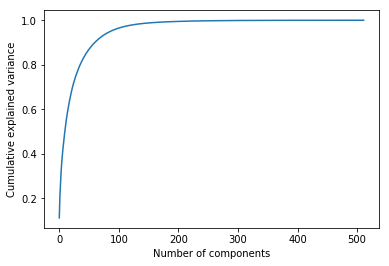

In [19]:
train_data_list, test_data_list = pca(train_data_list, test_data_list)

Model:  one Class SVM
Train accuracy: 0.8968842729970327
Test accuracy: 0.7317809400603709


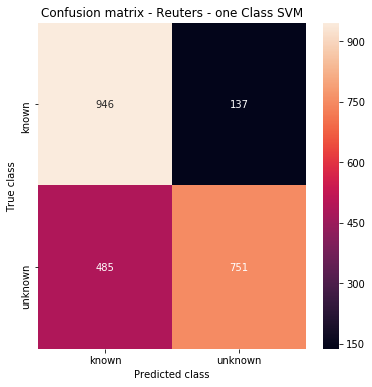

NameError: name 'classification_report' is not defined

In [20]:
svm_model = oneclass_svm(train_data_list, 'rbf', 0.1)
y_pred_train = svm_model.predict(train_data_list)
y_pred_test_svm = svm_model.predict(test_data_list)
results('one Class SVM', final_train['new_label'].tolist(), y_pred_train, final_test['new_label'].tolist(), y_pred_test_svm)

In [14]:
#train_scores_svm = svm_model.decision_function(train_data_list)
#test_scores_svm = svm_model.decision_function(test_data_list)
#print(train_scores)

Model:  Isolation Forest
Train accuracy: 0.9851632047477745
Test accuracy: 0.764984907287624


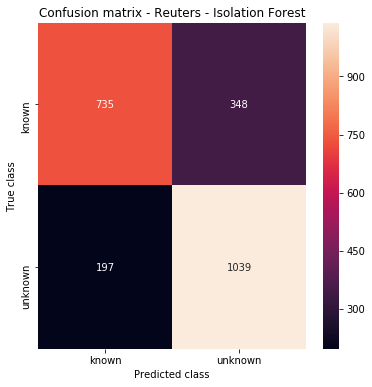

NameError: name 'classification_report' is not defined

In [21]:
rand_state = np.random.RandomState(42)
iso_forest = isolationForest(train_data_list, rand_state)
y_pred_iso_train = iso_forest.predict(train_data_list)
y_pred_iso_test = iso_forest.predict(test_data_list)
results('Isolation Forest', final_train['new_label'].tolist(), y_pred_iso_train, final_test['new_label'].tolist(), y_pred_iso_test)

Model:  Local Outlier Factory
Train accuracy: 0.8998516320474778
Test accuracy: 0.6998706338939198


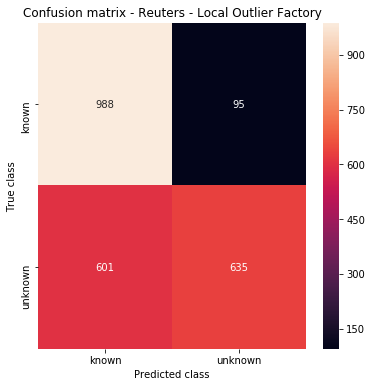

NameError: name 'classification_report' is not defined

In [22]:
lof = local_outlier_factory(train_data_list, 1000)
y_pred_lof_train = lof.predict(train_data_list)
y_pred_lof_test = lof.predict(test_data_list)
results('Local Outlier Factory', final_train['new_label'].tolist(), y_pred_lof_train, final_test['new_label'].tolist(), y_pred_lof_test)

In [23]:
# Converting the train and test data into dataframe
train_data_df = pd.DataFrame(train_data, columns = ['text' , 'label'])
test_data_df = pd.DataFrame(test_data, columns = ['text' , 'label'])
class_list = ['earn', 'acq', 'crude', 'interest', 'trade', 'ship', 'money-fx']
train_data_df = train_data_df[train_data_df['label'].isin(class_list)]
test_data_df = test_data_df[test_data_df['label'].isin(class_list)]
#train_data_df['label'].value_counts()
#test_data_df['label'].value_counts()

In [24]:
def data_for_autoencoder():
    # Numerical Labeling - 1 for normal class; -1 for anomaly class                    
    train_data_df['new_label'] = train_data_df['label']
    train_data_df.loc[train_data_df['label'] == 'earn', 'new_label'] = 0
    train_data_df.loc[train_data_df['label'] != 'earn', 'new_label'] = 1
    #train_data_df.loc[train_data_df['label'] == 'acq', 'new_label'] = 0
    test_data_df['new_label'] = test_data_df['label']
    test_data_df.loc[test_data_df['label'] == 'earn', 'new_label'] = 0
    test_data_df.loc[test_data_df['label'] != 'earn', 'new_label'] = 1
    #test_data_df.loc[test_data_df['label'] == 'acq', 'new_label'] = 0
    # Preparing train data with only normal class
    final_train = train_data_df.loc[train_data_df['new_label'] == 0]
    #df2 = [{'text': '', 'label': 'test', 'new_label': 1}, {'text': '', 'label': 'test', 'new_label': 1}, {'text': '', 'label': 'test', 'new_label': 1}, {'text': '', 'label': 'test', 'new_label': 1}, {'text': '', 'label': 'test', 'new_label': 1}, {'text': '', 'label': 'test', 'new_label': 1}, {'text': '', 'label': 'test', 'new_label': 1}, {'text': '', 'label': 'test', 'new_label': 1}]
    #final_train = final_train.append(df2, ignore_index=True)
    print(final_train['new_label'].value_counts())
    # Test data with both normal and other classes
    final_test = test_data_df
    print(final_test['new_label'].value_counts())
    return final_train, final_test

In [25]:
final_train, final_test = data_for_autoencoder()

0    2843
Name: new_label, dtype: int64
1    1236
0    1083
Name: new_label, dtype: int64


In [26]:
# Specify the embeddings 'glove', 'xlnet', 'fasttext', 'elmo', 'ensemble'
train_data_list, test_data_list = use_embeddings()
#train_data_list, test_data_list = bert_embeddings()
#train_data_list, test_data_list = infersent_embeddings()
#train_data_list, test_data_list = elmo_embeddings()
#train_data_list, test_data_list = other_embeddings('ensemble')

INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0109 14:42:18.916901 140281482052992 saver.py:1483] Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Graph was finalized.


I0109 14:42:19.219558 140281482052992 monitored_session.py:222] Graph was finalized.


INFO:tensorflow:Running local_init_op.


I0109 14:42:19.808072 140281482052992 session_manager.py:491] Running local_init_op.


INFO:tensorflow:Done running local_init_op.


I0109 14:42:20.895150 140281482052992 session_manager.py:493] Done running local_init_op.


In [27]:
X_train = train_data_list
y_train = final_train['new_label'].tolist()
X_test = test_data_list
y_test = final_test['new_label'].tolist()

In [28]:
X_train = np.asarray(X_train)
X_test = np.asarray(X_test)

In [29]:
input_dim = X_train.shape[1]
encoding_dim = 14
nb_epoch = 100
batch_size = 32

input_layer = Input(shape=(input_dim, ))
encoder = Dense(encoding_dim, activation="tanh", 
                activity_regularizer=regularizers.l1(10e-5))(input_layer)
encoder = Dense(int(encoding_dim / 2), activation="relu")(encoder)
decoder = Dense(int(encoding_dim / 2), activation='tanh')(encoder)
decoder = Dense(input_dim, activation='relu')(decoder)
autoencoder = Model(inputs=input_layer, outputs=decoder)


autoencoder.compile(optimizer='adam', 
                    loss='mean_squared_error', 
                    metrics=['accuracy'])

checkpointer = ModelCheckpoint(filepath="model_reuters.h5",
                               verbose=0,
                               save_best_only=True)
tensorboard = TensorBoard(log_dir='./logs_reuters',
                          histogram_freq=0,
                          write_graph=True,
                          write_images=True)

history = autoencoder.fit(X_train, X_train,
                    epochs=nb_epoch,
                    batch_size=batch_size,
                    shuffle=True,
                    validation_data=(X_test, X_test),
                    verbose=1,
                    callbacks=[checkpointer, tensorboard]).history

Instructions for updating:
Use tf.cast instead.


W0109 14:43:28.196328 140281482052992 deprecation.py:323] From /opt/conda/lib/python3.7/site-packages/tensorflow/python/ops/math_ops.py:3066: to_int32 (from tensorflow.python.ops.math_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.cast instead.


Train on 2843 samples, validate on 2319 samples
Epoch 1/100
2843/2843 [==============================] - 1s 210us/step - loss: 0.0023 - accuracy: 0.0566 - val_loss: 0.0020 - val_accuracy: 0.0970
Epoch 2/100
2843/2843 [==============================] - 0s 125us/step - loss: 0.0018 - accuracy: 0.1755 - val_loss: 0.0019 - val_accuracy: 0.0927
Epoch 3/100
2843/2843 [==============================] - 0s 130us/step - loss: 0.0016 - accuracy: 0.2054 - val_loss: 0.0018 - val_accuracy: 0.0927
Epoch 4/100
2843/2843 [==============================] - 0s 126us/step - loss: 0.0016 - accuracy: 0.2054 - val_loss: 0.0017 - val_accuracy: 0.0927
Epoch 5/100
2843/2843 [==============================] - 0s 130us/step - loss: 0.0016 - accuracy: 0.2054 - val_loss: 0.0017 - val_accuracy: 0.0927
Epoch 6/100
2843/2843 [==============================] - 0s 125us/step - loss: 0.0015 - accuracy: 0.2054 - val_loss: 0.0017 - val_accuracy: 0.0927
Epoch 7/100
2843/2843 [==============================] - 0s 149us/step

2843/2843 [==============================] - 0s 122us/step - loss: 0.0014 - accuracy: 0.3053 - val_loss: 0.0015 - val_accuracy: 0.2527
Epoch 57/100
2843/2843 [==============================] - 0s 135us/step - loss: 0.0014 - accuracy: 0.3173 - val_loss: 0.0015 - val_accuracy: 0.2734
Epoch 58/100
2843/2843 [==============================] - 0s 166us/step - loss: 0.0014 - accuracy: 0.3078 - val_loss: 0.0015 - val_accuracy: 0.2708
Epoch 59/100
2843/2843 [==============================] - 0s 163us/step - loss: 0.0014 - accuracy: 0.3078 - val_loss: 0.0015 - val_accuracy: 0.2501
Epoch 60/100
2843/2843 [==============================] - 0s 165us/step - loss: 0.0014 - accuracy: 0.3081 - val_loss: 0.0015 - val_accuracy: 0.2290
Epoch 61/100
2843/2843 [==============================] - 0s 154us/step - loss: 0.0014 - accuracy: 0.3078 - val_loss: 0.0015 - val_accuracy: 0.2385
Epoch 62/100
2843/2843 [==============================] - 0s 172us/step - loss: 0.0014 - accuracy: 0.3127 - val_loss: 0.0015 

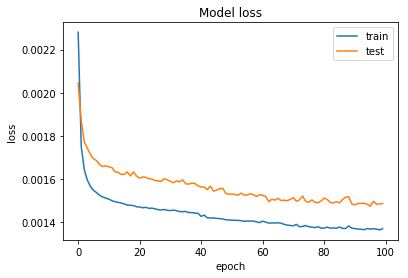

In [30]:
plt.plot(history['loss'])
plt.plot(history['val_loss'])
plt.title('Model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')

In [25]:
#Load the model for prediction
autoencoder = load_model('model_reuters.h5')
predictions = autoencoder.predict(X_test)

mse = np.mean(np.power(X_test - predictions, 2), axis=1)
error_df = pd.DataFrame({'reconstruction_error': mse,
                        'true_class': y_test})

error_df.describe()

,reconstruction_error,true_class
count,2319.000000,2319.000000
mean,0.001441,0.532988
std,0.000204,0.499018
min,0.001117,0.000000
25%,0.001290,0.000000
50%,0.001401,1.000000
75%,0.001550,1.000000
max,0.002263,1.000000


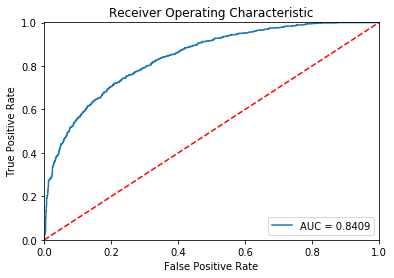

In [26]:
fpr, tpr, thresholds = roc_curve(error_df.true_class, error_df.reconstruction_error)
roc_auc = auc(fpr, tpr)

plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, label='AUC = %0.4f'% roc_auc)
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'r--')
plt.xlim([-0.001, 1])
plt.ylim([0, 1.001])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

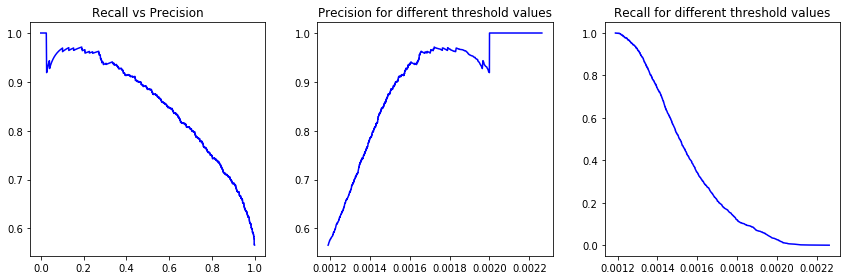

In [27]:
precision, recall, th = precision_recall_curve(error_df.true_class, error_df.reconstruction_error)
#plt.plot(recall, precision, 'b', label='Precision-Recall curve')

fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(12,4))
axes[0].plot(recall, precision, 'b', label='Precision-Recall curve')
axes[0].set_title('Recall vs Precision')
axes[1].plot(th, precision[1:], 'b', label='Threshold-Precision curve')
axes[1].set_title('Precision for different threshold values')
axes[2].plot(th, recall[1:], 'b', label='Threshold-Recall curve')
axes[2].set_title('Recall for different threshold values')
fig.tight_layout()

Maximum Test accuracy: 0.7546356188012074
Threshold for maximal accuracy:  0.0013940209


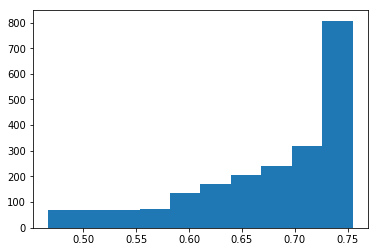

In [28]:
accuracies = []
for threshold in th:
    y_pred = [1 if e > threshold else 0 for e in error_df.reconstruction_error.values]
    accuracies.append(accuracy_score(error_df.true_class, y_pred))
print("Maximum Test accuracy:", max(accuracies))
#print(accuracies.index(max(accuracies)))
print('Threshold for maximal accuracy: ', th[accuracies.index(max(accuracies))])
threshold = th[accuracies.index(max(accuracies))]
fig = plt.figure()
ax = fig.add_subplot(111)
_ = ax.hist(accuracies)

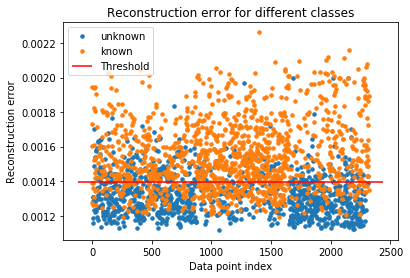

In [29]:
groups = error_df.groupby('true_class')
fig, ax = plt.subplots()
for name, group in groups:
    ax.plot(group.index, group.reconstruction_error, marker='o', ms=3.5, linestyle='',
            label= "known" if name == 1 else "unknown")
ax.hlines(threshold, ax.get_xlim()[0], ax.get_xlim()[1], colors="r", zorder=100, label='Threshold')
ax.legend()
plt.title("Reconstruction error for different classes")
plt.ylabel("Reconstruction error")
plt.xlabel("Data point index")
plt.show()

Test accuracy: 0.7546356188012074


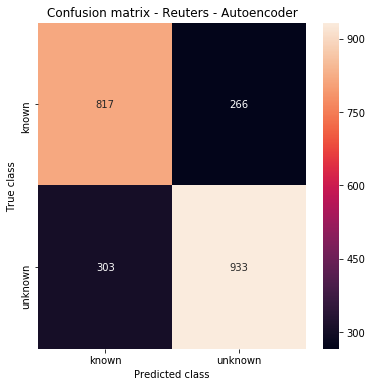

              precision    recall  f1-score   support

           0       0.73      0.75      0.74      1083
           1       0.78      0.75      0.77      1236

    accuracy                           0.75      2319
   macro avg       0.75      0.75      0.75      2319
weighted avg       0.76      0.75      0.75      2319



In [30]:
LABELS = ["known", "unknown"]
y_pred_autoencoder = [1 if e > threshold else 0 for e in error_df.reconstruction_error.values]
conf_matrix = confusion_matrix(error_df.true_class, y_pred_autoencoder,[0,1])
print("Test accuracy:", accuracy_score(error_df.true_class, y_pred_autoencoder))
plt.figure(figsize=(6,6))
sns.heatmap(conf_matrix, xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt="d");
plt.title("Confusion matrix - Reuters - Autoencoder")
plt.ylabel('True class')
plt.xlabel('Predicted class')
plt.show()
print(classification_report(error_df.true_class, y_pred_autoencoder))

Base individual models end. Ensemble approaches begin from here

In [31]:
for i in range(len(y_pred_autoencoder)):
    if y_pred_autoencoder[i] == 0:
        y_pred_autoencoder[i] = 1
    else:
        y_pred_autoencoder[i] = -1
#print(y_pred_autoencoder)

Model:  Ensemble
Test accuracy: 0.2065545493747305


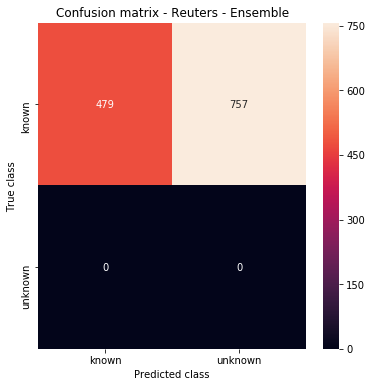

              precision    recall  f1-score   support

          -1       0.00      0.00      0.00         0
           0       0.00      0.00      0.00      1083
           1       0.34      0.39      0.36      1236

    accuracy                           0.21      2319
   macro avg       0.11      0.13      0.12      2319
weighted avg       0.18      0.21      0.19      2319



/opt/conda/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/classification.py:1439: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/classification.py:1439: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/opt/conda/lib/python3.7/site-packages/sklearn/m

In [32]:
import math as mt
def mostFrequent(arr): 
    n = len(arr)
    # Insert all elements in Hash. 
    Hash = dict() 
    for i in range(n): 
        if arr[i] in Hash.keys(): 
            Hash[arr[i]] += 1
        else: 
            Hash[arr[i]] = 1
  
    # find the max frequency 
    max_count = 0
    res = -1
    for i in Hash:  
        if (max_count < Hash[i]):  
            res = i 
            max_count = Hash[i] 
          
    return res  

def ensemble_results(model, test_true_labels, test_predicted_labels):
    print('Model: ', model)
    #print("Train accuracy:", accuracy_score(train_true_labels, train_predicted_labels))
    print("Test accuracy:", accuracy_score(test_true_labels, test_predicted_labels))
    results = confusion_matrix(test_true_labels, test_predicted_labels, [1,-1]) 
    #print('Confusion Matrix :')
    #print(results) 
    #print('Report : ')
    LABELS = ["known", "unknown"]
    plt.figure(figsize=(6, 6))
    sns.heatmap(results, xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt="d");
    plt.title("Confusion matrix - Reuters - " + str(model))
    plt.ylabel('True class')
    plt.xlabel('Predicted class')
    plt.show()
    print(classification_report(test_true_labels, test_predicted_labels))

'''y_pred_train_ensemble = []
for i in range(len(final_train['new_label'].tolist())):
    train_arr = [ y_pred_train[i], y_pred_iso_train[i], y_pred_lof_train[i]]
    y_pred_train_ensemble.append(mostFrequent(train_arr))
'''
y_pred_test_ensemble = []

for i in range(len(final_test['new_label'].tolist())):
    arr = [ y_pred_test_svm[i], y_pred_iso_test[i], y_pred_lof_test[i], y_pred_autoencoder[i]]
    y_pred_test_ensemble.append(mostFrequent(arr))

ensemble_results('Ensemble', final_test['new_label'].tolist(), y_pred_test_ensemble)

In [ ]:
y_pred_cvdd = [1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0] 
for elem in y_pred_cvdd:
    if elem == 1.0:
        elem = -1
    if elem == 0.0:
        elem = 1
print(len(y_pred_cvdd))

In [ ]:
from pyod.models.combination import aom, moa, average, maximization
from pyod.utils.utility import standardizer
from pyod.utils.data import evaluate_print

In [ ]:
print(np.asarray(train_scores_svm).shape)
print(np.asarray(train_scores_iso).shape)

In [ ]:
#train_svm = np.asarray(train_scores_svm)
#train_iso = np.asarray(train_scores_iso)
#trian_lof = np.asarray(train_scores_lof)
#print(type(train_svm))
new_arr_train = np.array((train_scores_svm, train_scores_iso, train_scores_lof)).transpose()
new_arr_test = np.array((test_scores_svm, test_scores_iso, test_scores_lof)).transpose()

In [ ]:
train_comb_norm_score, test_comb_norm_score = standardizer(new_arr_train, new_arr_test)

In [ ]:
print('Decision score matrix on training data', train_comb_norm_score.shape)
print('Decision score matrix on test data', test_comb_norm_score.shape)

In [ ]:
y_by_average = average(test_comb_norm_score)
print(y_by_average)

In [ ]:
 #Combine and evaluate the combination result

# Combination by average
y_by_average = average(test_comb_norm_score)
evaluate_print('Combination by Average', np.asarray(final_test['new_label'].tolist()), y_by_average)

# Combination by max
y_by_maximization = maximization(test_comb_norm_score)
evaluate_print('Combination by Maximization', np.asarray(final_test['new_label'].tolist()), y_by_maximization)

# Combination by aom
y_by_aom = aom(test_comb_norm_score, n_buckets=5)
evaluate_print('Combination by AOM', np.asarray(final_test['new_label'].tolist()), y_by_aom)

# Combination by moa
y_by_moa = moa(test_comb_norm_score, n_buckets=5)
evaluate_print('Combination by MOA', np.asarray(final_test['new_label'].tolist()), y_by_moa)